In [65]:
import uproot
import uproot_methods.classes.TLorentzVector as LVepm
import matplotlib.pyplot as plt
import time
import infofile
import numpy as np
import mplhep as hep

In [161]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    #print("sample =  " + str(sample) + str(info["xsec"]) + " " +  str(info) )
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

In [220]:
files = [
"mc_361106.Zee.4lep.root",
"mc_361107.Zmumu.4lep.root",
"mc_410000.ttbar_lep.4lep.root",
"mc_363490.llll.4lep.root",
"mc_363492.llvv.4lep.root",
"mc_363356.ZqqZll.4lep.root",    
"mc_345060.ggH125_ZZ4lep.4lep.root",
"mc_341964.WH125_ZZ4lep.4lep.root",
"mc_344235.VBFH125_ZZ4lep.4lep.root",
"mc_341947.ZH125_ZZ4lep.4lep.root",
"data.4lep.root"  
]

File has been successfully opened!
Sample Name = mc_361106.Zee.4lep.root exp. num. events = 30.389212
File has been successfully opened!
Sample Name = mc_361107.Zmumu.4lep.root exp. num. events = 41.127514
File has been successfully opened!
Sample Name = mc_410000.ttbar_lep.4lep.root exp. num. events = 10.320093
File has been successfully opened!
Sample Name = mc_363490.llll.4lep.root exp. num. events = 245.95114
File has been successfully opened!
Sample Name = mc_363492.llvv.4lep.root exp. num. events = 0.14646414
File has been successfully opened!
Sample Name = mc_363356.ZqqZll.4lep.root exp. num. events = 0.15270728
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
['Zee', 'Zmumu', 'ttbar_lep', 'llll', 'llvv', 'ZqqZll', 'ggH125_ZZ4lep', 'WH125_ZZ4lep', 'VBFH125_ZZ4lep', 'ZH125_ZZ4lep', '4lep']


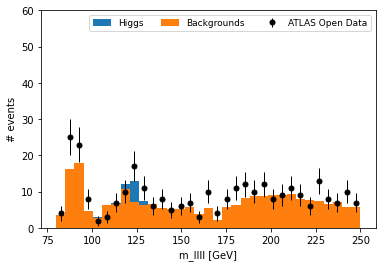

In [236]:
lumi = 10#fb^-1
nBins = 34
minMass = 80
maxMass = 250

bins_ar = np.linspace(minMass, maxMass, num=nBins)
mc_hist_list = []
sample_names = []

f = plt.figure()

H_125 = np.zeros([nBins-1])
H_bkg = np.zeros([nBins-1])



for file in files:
    sample_name = file.split(".")[1] 
    sample_names.append(sample_name)
    tree = uproot.open(file)["mini"]

    mcWeight, SumWeights, XSection, trigM, trigE, scaleFactor_PILEUP, scaleFactor_ELE, scaleFactor_MUON,scaleFactor_LepTRIGGER, lep_type, lep_pt, lep_eta, lep_phi, lep_E, lep_charge, lep_etcone20, lep_ptcone30, jet_n, jet_pt, jet_eta, jet_phi, jet_E, jet_MV2c10 = tree.arrays(["mcWeight", "SumWeights", "XSection","trigM", "trigE","scaleFactor_PILEUP", "scaleFactor_ELE", "scaleFactor_MUON","scaleFactor_LepTRIGGER","lep_type","lep_pt", "lep_eta","lep_phi", "lep_E", "lep_charge", "lep_etcone20", "lep_ptcone30", "jet_n", "jet_pt", "jet_eta", "jet_phi","jet_E", "jet_MV2c10"], outputtype=tuple)
    print("File has been successfully opened!")
    
    leplv = LVepm.TLorentzVectorArray.from_ptetaphi(lep_pt, lep_eta, lep_phi, lep_E)

    lep_reliso_pt = (lep_ptcone30 / lep_pt)
    lep_reliso_et = (lep_etcone20 / lep_pt)
    
    sum_lep_type = lep_type.sum()

    
    trig_cut = ( (trigM==1) | (trigE==1))
    lep_kinematics_cut  = ( (lep_pt.max() > 25000) & (lep_pt.min() > 7000) & (lep_eta.min() >-2.5) & (lep_eta.max() < 2.5))
    lep_type_cut  = ((sum_lep_type == 44) | (sum_lep_type == 48) | (sum_lep_type == 52))
    lep_iso_cut =  ((lep_reliso_pt.max() < 0.3) & (lep_reliso_pt.max() < 0.3))
    lept_count_cut = (leplv.counts ==4)
    lept_charge_cut = (lep_charge.sum()==0)
    
    event_cut = ( trig_cut & lep_kinematics_cut & lep_type_cut & lep_iso_cut  & lept_count_cut &lept_charge_cut)

    first_lep_p4 =  leplv[event_cut,0]
    second_lep_p4 = leplv[event_cut,1]
    third_lep_p4 =  leplv[event_cut,2]
    fourth_lep_p4 = leplv[event_cut,3]
    mcWeight = mcWeight[event_cut] 
    
    scaleFactor_PILEUP = scaleFactor_PILEUP[event_cut] 
    scaleFactor_ELE = scaleFactor_ELE[event_cut] 
    scaleFactor_MUON = scaleFactor_MUON[event_cut] 
    scaleFactor_LepTRIGGER = scaleFactor_LepTRIGGER[event_cut] 
    
    llll_p4 = first_lep_p4 + second_lep_p4 + third_lep_p4 + fourth_lep_p4   
    
    if(file.split("_")[0] == "mc"):
        finalWeight = get_xsec_weight(sample_name)*(mcWeight)*(scaleFactor_PILEUP)*(scaleFactor_ELE) *(scaleFactor_MUON)*(scaleFactor_LepTRIGGER)
        H, b = np.histogram(llll_p4.mass/1000.0, weights=finalWeight, bins=bins_ar)                        
        mc_hist_list.append(H)
        if("H125" in file):
            H_125 = np.add(H, H_125)
        else:
            print("Sample Name = " + str(file) + " exp. num. events = " + str(np.sum(finalWeight)) )
            H_bkg = np.add(H, H_bkg)
    
    else:
        finalWeight = np.ones(len(mcWeight)) 
        sample_name = "Data (10 fb^-1)"
        H_data, b = np.histogram(llll_p4.mass/1000.0, weights=finalWeight, bins=bins_ar)
        
print(sample_names)
hep.histplot([H_bkg, H_125], bins=bins_ar, stack=True, label=["Backgrounds", "Higgs"], histtype='fill')
#hep.histplot([H_bkg], bins=bins_ar, stack=True, label="Backgrounds", histtype='fill')

#hep.histplot(mc_hist_list, bins=bins_ar, stack=True, label=sample_names[:-1], histtype='fill')
hep.histplot([H_data], bins=bins_ar, stack=False, yerr=True, histtype="errorbar", color="black",label="ATLAS Open Data")

plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("m_llll [GeV]")
plt.ylabel("# events")
#plt.yscale("log")
plt.ylim([0.0, 60])
plt.show()

In [ ]:
weight = 1.0 #default weight to assign to each event
lumi = 10000.0 #total intgegrated luminosity of the data
frac = 1.0 # fraction of the MC we want to process (set to a small fraction for quick tests)
mZ = 91.18

nSelEvents = 0

for f in files:
    tree = ROOT.RDataFrame("mini", files[f])
    #tree = files[f].Get("mini")

    print("samples = "+ str(f) + " with " + str(tree.GetEntries()))
    
    Lepton_1 = ROOT.TLorentzVector()
    Lepton_2 = ROOT.TLorentzVector()

    zCand = ROOT.TLorentzVector()
    hCand = ROOT.TLorentzVector()

    n = 0
    #for event in tree:
    if ("data" in f):
        maxEvents = tree.GetEntries()
    else:
        maxEvents = int(tree.GetEntries()*frac)

    for event in range(0,maxEvents):
        tree.GetEvent(event)
        zCands = []
        hCands = []
        rawLeps = []
                
        if ("data" in f):
            weight = 1.0
        else:
            effLumi = (tree.SumWeights*frac)/(tree.XSection)
            sf  = tree.scaleFactor_PILEUP*tree.scaleFactor_LepTRIGGER*tree.scaleFactor_ELE*tree.scaleFactor_MUON
            weight = (tree.mcWeight)*(lumi/effLumi)

        n += 1
        ## printing the evolution in number of events
        if(n%20000==0):
            print(str(n) + " / " + str(tree.GetEntries()) + " events processed, " + str(nSelEvents) + " events selected"  ) 
        
        #apply some criteria before processing the event
        
        # 1) require either the single muon or single electron trigger to have fired.
        if((tree.trigM==0) and (tree.trigE==0)):
            continue

        #2) require the total number of leptons to be at least 4
        if(len(tree.lep_phi) < 4):
            continue
            
        #make TLorentzVector obejcts for each lepton, fill them into a vector and sorted by pt
        for j in range(0, len(tree.lep_phi)):
            rawLepton = ROOT.TLorentzVector()
            rawLepton.SetPtEtaPhiE(tree.lep_pt[j]/1000., tree.lep_eta[j], tree.lep_phi[j],tree.lep_E[j]/1000.)
            rawLeps.append(rawLepton)
        rawLepsSorted = sorted(rawLeps, key=lambda obj: obj.Pt(), reverse=True)

        if ((rawLepsSorted[0].Pt() < 25.0) or (rawLepsSorted[1].Pt() < 15.0) or (rawLepsSorted[2].Pt() < 10.0) or (rawLepsSorted[3].Pt() < 7.0)):
            continue
    
        for j in range(0, len(tree.lep_phi)):
            #print("pt iso = " + str(tree.lep_ptcone30[j] / tree.lep_pt[j]) + " et iso =  " + str(tree.lep_etcone20[j] / tree.lep_pt[j]))
            Lepton_1.SetPtEtaPhiE(tree.lep_pt[j]/1000., tree.lep_eta[j], tree.lep_phi[j],tree.lep_E[j]/1000.)
            for k in range(0, len(tree.lep_phi)):  
                Lepton_2.SetPtEtaPhiE(tree.lep_pt[k]/1000., tree.lep_eta[k], tree.lep_phi[k],tree.lep_E[k]/1000.)
                if((tree.lep_pt[j] > 7000) and (TMath.Abs(tree.lep_eta[j]) < 2.5) and (tree.lep_ptcone30[j] / tree.lep_pt[j] < 0.3) and (tree.lep_etcone20[j] / tree.lep_pt[j] < 0.3) and (tree.lep_charge[j] == -1)  and (TMath.Abs(tree.lep_trackd0pvunbiased[j]/tree.lep_tracksigd0pvunbiased[j]) < 5) and (TMath.Abs(tree.lep_z0[j]*TMath.Sin(Lepton_1.Theta())) < 0.5)  ):
                    if((tree.lep_pt[k] > 7000) and (TMath.Abs(tree.lep_eta[k]) < 2.5) and (tree.lep_ptcone30[k] / tree.lep_pt[k] < 0.3) and (tree.lep_etcone20[k] / tree.lep_pt[k] < 0.3) and (tree.lep_charge[k] == 1) and (TMath.Abs(tree.lep_trackd0pvunbiased[k]/tree.lep_tracksigd0pvunbiased[k]) < 5) and (TMath.Abs(tree.lep_z0[k]*TMath.Sin(Lepton_2.Theta())) < 0.5) ):                
                        if (TMath.Abs(tree.lep_type[j]) == TMath.Abs(tree.lep_type[k])):
                            zCand = Lepton_1 + Lepton_2
                            zCands.append(zCand)
 
        zCandsSorted = sorted(zCands, key=lambda obj: abs(mZ - obj.M()))
                
        if (len(zCands) > 1):
            nSelEvents += 1
            hCand = zCandsSorted[0] + zCandsSorted[1]
            hCands.append(hCand) 

        for hCand in hCands:
            if("data" in f):
                histos["Data"].Fill(hCand.M(), weight)
            elif("H" in f):
                histos["Higgs"].Fill(hCand.M(), weight)
            elif("ZZ" in f):
                histos["ZZ"].Fill(hCand.M(), weight)
            else:
                histos["Other"].Fill(hCand.M(), weight)
